# Graph Classification

Build a GNN to predict whether a molecule inhibits HIV virus replication or not (i.e. a binary target) given its molecular structure as a graph.

We will use the [ogbg-molhiv](https://ogb.stanford.edu/docs/graphprop/#ogbg-mol) dataset to train and evaluate our GNN.

## Setup

The following two cells import Pytorch and some supporting packages that depend on the version of Pytorch, as well as Pytorch Geometric (PyG) and the OGB package. 

We need [Open Graph Benchmark (OGB)](https://ogb.stanford.edu/docs/home/) package here for its `PygGraphPropPredDataset` dataset loader and the `AtomEncoder` (more on that below).


In [ ]:
import torch
torch.__version__

'1.9.0+cu111'

In [ ]:
%%capture
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
!pip install -q torch-geometric
!pip install ogb

## Dataset

The [ogbg-molhiv](https://ogb.stanford.edu/docs/graphprop/#ogbg-mol) dataset is part of the [MoleculeNet](https://pubs.rsc.org/en/content/articlehtml/2018/sc/c7sc02664a) dataset. 

The dataset contains 41,127 molecules, each represented as a graph. Each graph represents a molecule, where nodes are atoms, and edges are chemical bonds. Input node features are 9-dimensional, containing atomic number and chirality, as well as other additional atom features such as formal charge and whether the atom is in the ring or not. Each molecule contains a 0 or 1 label, indicating whether the molecule inhibits HIV virus replication or not.

Use the `PygGraphPropPredDataset` loader to retrieve the `ogbg-molhiv` dataset. To see how this is done, refer to the Data Loaders section of the [OGB documentation](https://ogb.stanford.edu/docs/home/).

Once the dataset is downloaded, find and confirm the following details.

1. Number of features for each node (should be 9)
2. Number of targets (should be 2)
3. Number of graphs in dataset (should be 41127)

In [ ]:
from ogb.graphproppred import PygGraphPropPredDataset

In [ ]:
dataset = PygGraphPropPredDataset(name='ogbg-molhiv')
dataset

PygGraphPropPredDataset(41127)

In [ ]:
dataset.num_features

9

In [ ]:
dataset.num_classes

2

In [ ]:
len(dataset)

41127

## Visualize Dataset

Pick a random graph from the dataset and visualize what it looks like. You can do it in at one of at least two ways.

* __Using the edge_index__ -- extract the `edge_index` from the `Data` object and reformat it as a list of node tuples. Create a networkx graph using `networkx.from_edgelist(edges)` then use `networkx.draw()` to draw the graph.
* __Using PyG utils__ -- PyG offers a `utils.to_networkx()` that takes a `Data` object directly. Use that to create a `networkx` graph object, then use `networkx.draw()` to draw the graph.

In [ ]:
import networkx as nx
import torch_geometric.utils as pyg_utils

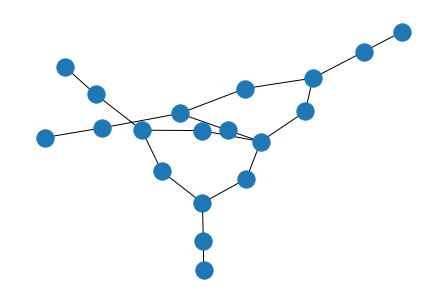

In [ ]:
def draw_graph(edge_index, gids=[]):
  src = edge_index[0].tolist()
  dst = edge_index[1].tolist()
  edges = [(s, d) for s, d in zip(src, dst)]
  G = nx.from_edgelist(edges)
  nx.draw(G)

draw_graph(dataset[0].edge_index)

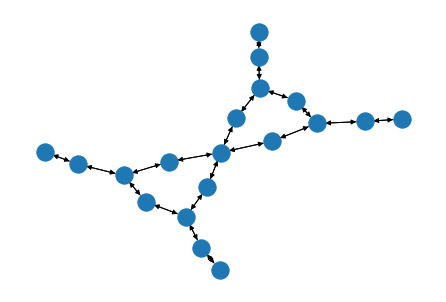

In [ ]:
G = pyg_utils.to_networkx(dataset[0])
nx.draw(G)

## Visualize Label Distribution

As expected, the dataset is very heavily skewed towards molecules that don't inhibit HIV replication.

Verify that the dataset is heavily skewed. Compute the label distribution and visualize it using a histogram.

In [ ]:
import matplotlib.pyplot as plt

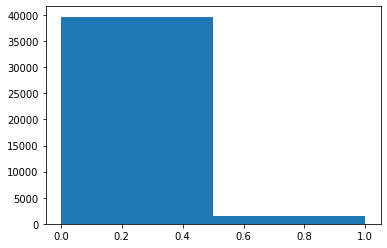

In [ ]:
labels = [data.y for data in dataset]
plt.hist(labels, bins=2)
_ = plt.show()

## Split and DataLoader

The dataset created using `PygGraphPropPredDataset` comes with a `get_idx_splits()` function that provides indices for train, validation and test splits.

Extract this information and use it to build the training, validation and test DataLoaders. Refer to the Data Loaders section of the [OGB Documentation](https://ogb.stanford.edu/docs/home/) page to see how to do this.

In [ ]:
from torch_geometric.loader import DataLoader

In [ ]:
split_idx = dataset.get_idx_split()
split_idx

{'test': tensor([    0,     1,     2,  ..., 10122, 10124, 10125]),
 'train': tensor([    3,     4,     5,  ..., 41124, 41125, 41126]),
 'valid': tensor([10127, 10129, 10132,  ..., 22785, 22786, 22788])}

In [ ]:
BATCH_SIZE = 32

train_loader = DataLoader(dataset[split_idx["train"]], batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset[split_idx["valid"]], batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=BATCH_SIZE)

## Model

The model we will use is very similar to our node classification model. 

As before, we have a variable number of `GCNConv` layers that determine how large a neighborhood we are considering for each node (k GCN layers == k-hop neighborhood).

However, in this case we are using the GCN layers as a graph encoder. Assuming that the output of the last GCN has dimension _H_ and the number of nodes in a graph is _N_, then the encoding for that graph after passing through the GCN layers is _(H, N)_.

Each graph can have variable number of nodes, so we then pass this data through a pooling layer that pools across all the nodes in the graph, giving us a vector of size _(H)_ for each graph.

A batch of these vectors are then fed into the classifier head, which is one or more Linear layers that project the vectors from the hidden dimension to the output dimension, i.e. the number of classes.

---

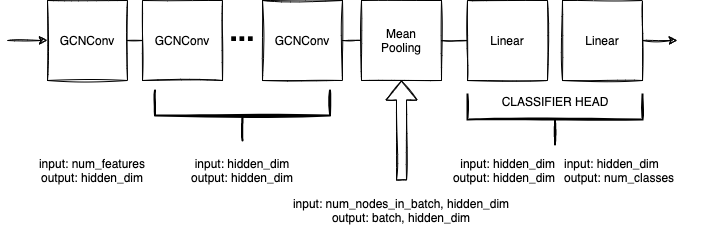

---
Build the GNN model for graph prediction with the following layers.

1. An `AtomEncoder` layer to convert from the 9 categorical features based on the chemical properties of each node (atom) in the molecule into a fixed size hidden representation _H_ (should be parameterized). Refer to the Module section of the [OGB Documentation](https://ogb.stanford.edu/docs/graphprop/) for more information.
2. _(k - 1)_ layers, where _k_ is the number of graph layers requested (should be parameterized).
  * `GCNConv` layer with input and output dimensions _H_.
  * A `torch.nn.BatchNorm1d` layer with _H_ features.
  * A `torch.nn.ReLU` activation layer
  * A `torch.nn.Dropout` layer (dropout percentage should be parameterized)
3. The _k-th_ layer is a `GCNConv` with input and output dimensions _H_.
3. A `torch_geometric.global_mean_pool` pooling layer that pools across the batch of node features.
4. A single `torch.nn.Linear` layer to project the batch of vectors with dimension _H_ to the target dimension (number of classes, should be parameterized).

Test the model using a batch of data from the train DataLoader and verify that the input and output are correct.



In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

from ogb.graphproppred.mol_encoder import AtomEncoder

In [ ]:
class GraphClassifier(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, 
               num_graph_layers, dropout_pct):

    super(GraphClassifier, self).__init__()
    self.num_graph_layers = num_graph_layers
    self.dropout_pct = dropout_pct
    self.output_dim = output_dim

    # convert manually crafted categorical features to continuous
    self.encoder = AtomEncoder(hidden_dim)

    self.convs = nn.ModuleList()
    for i in range(num_graph_layers):
      self.convs.append(pyg_nn.GCNConv(hidden_dim, hidden_dim))

    self.bns = nn.ModuleList()
    for i in range(num_graph_layers - 1):
      self.bns.append(nn.BatchNorm1d(hidden_dim))

    self.clf_head = nn.Linear(hidden_dim, output_dim)

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    x = self.encoder(x)
    for i in range(self.num_graph_layers - 1):
      x = self.convs[i](x, edge_index)
      x = self.bns[i](x)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout_pct)
    x = self.convs[-1](x, edge_index)

    x = pyg_nn.global_mean_pool(x, data.batch)
    x = self.clf_head(x)
    return x



In [ ]:
model = GraphClassifier(dataset.num_features, 100, 
                        dataset.num_classes, 3, 0.5)
for batch in train_loader:
  print(batch)
  pred = model(batch)
  break
  
pred.size()

DataBatch(edge_index=[2, 1560], edge_attr=[1560, 3], x=[731, 9], y=[32, 1], batch=[731], ptr=[33])


torch.Size([32, 2])

## Training Loop

As with our node classification example, the training loop is composed of alternate calls to `train_step` and `eval_step` functions over multiple epochs of training.

However, unlike the node classification example, we will use ROC-AUC as our evaluation criteria rather than accuracy. The [rationale for this choice](https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy) is explained in detail in the accepted answer in this Stack Exchange page. Basically, AUC is a better metric to gauge the strength of our model compared to accuracy because:

* our dataset is skewed
* our task is binary classification
* AUC forces model selection that are more discriminative.

The [Scikit-Learn documentation page on ROC-AUC]((https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics)) provides additional intuition about the ROC-AUC metric.

So our steps are as follows:

1. Build the `train_step` function with the following signature. You can copy-paste most of what you built in the previous exercise except for some important differences.
    * the size of the batch is given by `batch.num_graphs` and not just `len(batch)`
    * we are using a different loss function `BCEWithLogits` instead of `NLLLoss`, that might require changes to how you compute the loss.
    * We will need to compute the ROC-AUC instead of the accuracy per batch in our `train_step` and `eval_step` functions.
    * At the end of each batch, accumulate a data structure `label_preds` which is a tuple of (label:Float, prediction:Array`[(Float, Float)]` and return it along with the `loss` and `accuracy`.

```python
def train_step(model: torch.nn.Module, 
               optimizer: torch.optim.Optimizer, 
               loss_fn, torch.nn.CrossEntropyLoss,
               train_loader: torch_geometric.loader.DataLoader,
               device: torch.Device
              ) -> (
               train_loss: Float, 
               train_acc: Float,
               label_preds: List[(Float, [Float, Float])]
              )
```

2. Build the `eval_step` function with the signature given below. As before, the same code should be usable for validation and testing by appropriately setting the `is_validation` parameter. Also you may be able to copy-paste the code from the previous exercise here as well, with the same caveats listed in the instructions for the `train_step`.

As with the `train_step`, accumulate and return the `label_preds` data structure.

```python
def eval_step(model: torch.nn.Module, 
              loss_fn: torch.nn.CrossEntropyLoss, 
              eval_loader: torch_geometric.loader.DataLoader,
              device: torch.Device, 
              is_validation=False: boolean
            ) -> (
              eval_loss: Float,
              eval_acc: Float,
              label_preds: List[Float, [Float, Float]]
            )
```

3. Build the `train_loop` function with the following signature. You should be able to copy-paste this directly from the node classification exercise. It takes in a union of parameters required by the `train_step` and `eval_step` and produces a `history` list of the tuple `(train_loss, train_acc, train_auc, val_loss, val_acc, val_auc)` for drawing the loss plots. It periodically (`log_every`) writes out the values to console.

Use the `roc_auc_score` from Scikit-Learn to compute the ROC-AUC score for training and validation from the `label_preds` data structure, and report it along with the train and validation loss and accuracy.

```python
def train_loop(model: torch.nn.Module, 
               optimizer: torch.optim.Optimizer, 
               loss_fn: torch.nn.CrossEntropyLoss, 
               train_loader: torch_geometric.loader.DataLoader,
               val_loader: torch_geometric.loader.DataLoader,
               device: torch.Device, 
               num_epochs: Int, 
               log_every=5: Int
              ) -> List[(Float, Float, Float, 
                         Float, Float, Float)]

```

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
def train_step(model, optimizer, loss_fn, train_loader, device):
  model.train()
  total_rows, total_loss, total_correct = 0, 0, 0
  label_preds = []
  for batch in train_loader:
    batch = batch.to(device)
    optimizer.zero_grad()
    pred = model(batch)
    # label = batch.y.squeeze(dim=-1)
    label = batch.y.squeeze(dim=-1)
    label_cat = F.one_hot(label, num_classes=2).float()

    loss = loss_fn(pred, label_cat)
    loss.backward()
    optimizer.step()
    # update values for reporting
    total_loss += loss.item()
    total_correct += pred.argmax(dim=-1).eq(label).sum().item()
    total_rows += batch.num_graphs
    label_preds.extend(zip(label.detach().cpu().numpy(),
                           pred.detach().cpu().numpy()))

  return total_loss / total_rows, total_correct / total_rows, label_preds


def eval_step(model, loss_fn, eval_loader, device, is_validation=False):
  model.eval()
  total_rows, total_loss, total_correct = 0, 0, 0
  label_preds = []
  for batch in eval_loader:
    batch = batch.to(device)
    with torch.no_grad():
      pred = model(batch)
      label = batch.y.squeeze(dim=-1)
      label_cat = F.one_hot(label, num_classes=2).float()

      loss = loss_fn(pred, label_cat)
      total_loss += loss.item()
      total_correct += pred.argmax(dim=-1).eq(label).sum().item()
      total_rows += batch.num_graphs
      label_preds.extend(zip(label.cpu().numpy(),
                             pred.cpu().numpy()))

  return total_loss / total_rows, total_correct / total_rows, label_preds


def compute_roc_auc(label_preds):
  y_true, y_score = [], []
  for label, preds in label_preds:
    y_true.append(label)
    y_score.append(preds[1])
  return roc_auc_score(y_true, y_score)


def train_loop(model, optimizer, loss_fn, train_loader, val_loader, device, 
               num_epochs, log_every=5):
  history = []
  for epoch in range(num_epochs):
    train_loss, train_acc, train_label_preds = train_step(model, optimizer, loss_fn, 
                                       train_loader, device)
    val_loss, val_acc, val_label_preds = eval_step(model, loss_fn, val_loader, 
                                  device, is_validation=True)
    
    # compute ROC-AUC for training and validation
    train_auc = compute_roc_auc(train_label_preds)
    val_auc = compute_roc_auc(val_label_preds)

    history.append((train_loss, train_acc, train_auc, val_loss, val_acc, val_auc))
    if epoch == 0 or (epoch + 1) % log_every == 0:
      print("EPOCH {:3d}, TRAIN loss: {:.5f}, acc: {:.5f}, AUC: {:.5f}, VAL loss: {:.5f}, acc: {:.5f}, AUC: {:.5f}"
        .format(epoch + 1, train_loss, train_acc, train_auc, val_loss, val_acc, val_auc))

  return history


## Training

Now train the network using the hyperparameters in the cell below.

1. At this point, if your code runs without errors, you can switch from using CPU to GPU. To do so, go to Runtime :: Change Runtime Type and setting Hardware Accelerator to GPU. You will need to rerun the notebook from the beginning once you switch from CPU to GPU.
2. Set the device to `torch.device("cuda")` if GPU is available otherwise set it to `torch.device("cpu")`.
3. Instantiate the GNN model and set the model to the appropriate device using `model.to(device)`.
4. Define the loss function to be `torch.nn.CrossEntropyLoss`.
5. Instantiate the `torch.optim.Adam` optimizer with model parameters and the appropriate `LEARNING_RATE` parameters.
6. Run the training loop for `NUM_EPOCHS` epochs and capture the training and validation losses and accuracies returned.
7. Use the training and validation losses and accuracies tuple to plot the loss and accuracy curves for the model training (the plotting code should be identical to the one you built in the previous Node Classification exercise).

In [ ]:
# model parameters
INPUT_DIM = dataset.num_features
HIDDEN_DIM = 256
OUTPUT_DIM = dataset.num_classes
NUM_GCN_LAYERS = 5
DROPOUT_PCT = 0.5

# optimizer
LEARNING_RATE = 1e-3

NUM_EPOCHS = 30

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = GraphClassifier(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_GCN_LAYERS, DROPOUT_PCT)
model = model.to(device)

In [ ]:
import torch.optim as optim

# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
history = train_loop(model, optimizer, loss_fn, train_loader, val_loader, device, NUM_EPOCHS)

EPOCH   1, TRAIN loss: 0.00497, acc: 0.96176, AUC: 0.63007, VAL loss: 0.00283, acc: 0.98031, AUC: 0.68051
EPOCH   5, TRAIN loss: 0.00441, acc: 0.96237, AUC: 0.74059, VAL loss: 0.00258, acc: 0.98006, AUC: 0.77832
EPOCH  10, TRAIN loss: 0.00426, acc: 0.96252, AUC: 0.75892, VAL loss: 0.00265, acc: 0.98128, AUC: 0.76225
EPOCH  15, TRAIN loss: 0.00410, acc: 0.96353, AUC: 0.78135, VAL loss: 0.00272, acc: 0.98128, AUC: 0.73997
EPOCH  20, TRAIN loss: 0.00401, acc: 0.96374, AUC: 0.79701, VAL loss: 0.00259, acc: 0.98055, AUC: 0.78297
EPOCH  25, TRAIN loss: 0.00394, acc: 0.96426, AUC: 0.80112, VAL loss: 0.00249, acc: 0.98201, AUC: 0.77095
EPOCH  30, TRAIN loss: 0.00390, acc: 0.96444, AUC: 0.81127, VAL loss: 0.00263, acc: 0.98201, AUC: 0.77377


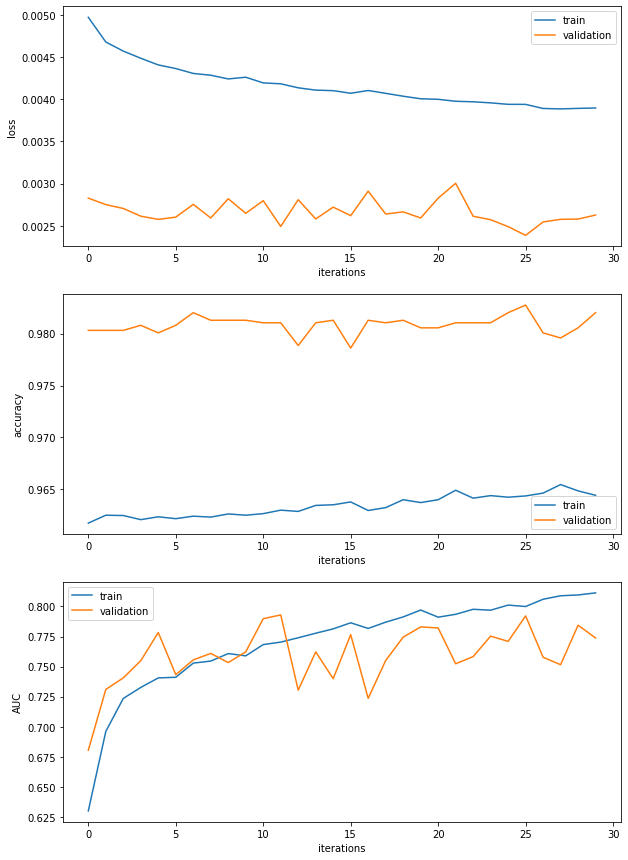

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_training_plots(history):
  train_losses, train_accs, train_aucs, val_losses, val_accs, val_aucs = [], [], [], [], [], []
  for train_loss, train_acc, train_auc, val_loss, val_acc, val_auc in history:
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_aucs.append(train_auc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_aucs.append(val_auc)

  xs = np.arange(len(train_losses))

  plt.figure(figsize=(10, 15))

  plt.subplot(3, 1, 1)
  plt.plot(xs, train_losses, label="train")
  plt.plot(xs, val_losses, label="validation")
  plt.xlabel("iterations")
  plt.ylabel("loss")
  plt.legend(loc="best")

  plt.subplot(3, 1, 2)
  plt.plot(xs, train_accs, label="train")
  plt.plot(xs, val_accs, label="validation")
  plt.xlabel("iterations")
  plt.ylabel("accuracy")
  plt.legend(loc="best")

  plt.subplot(3, 1, 3)
  plt.plot(xs, train_aucs, label="train")
  plt.plot(xs, val_aucs, label="validation")
  plt.xlabel("iterations")
  plt.ylabel("AUC")
  plt.legend(loc="best")

  _ = plt.show()


display_training_plots(history)

## Evaluation

Now evaluate your trained model on the held out test set, reporting both accuracy and AUC scores. You can reuse the `eval_step()` function that you used for evaluating the model with the validation set during the training.

Report the accuracy and AUC score values on the test set to 5 decimal places.

In [ ]:
_, test_acc, test_list_preds = eval_step(model, loss_fn, test_loader, device)
test_auc = compute_roc_auc(test_list_preds)
print("Test accuracy: {:.5f}".format(test_acc))
print("Test AUC: {:.5f}".format(test_auc))

Test accuracy: 0.96791
Test AUC: 0.76267


## Repeat Classification using AUC instead of Accuracy

## Repeat Classification with MAX Pooling

Investigate the effect on the graph classification accuracy by changing the global pooling strategy to MAX, i.e. `torch_geometric.nn.global_max_pool`. Here are the steps.

1. Either copy-paste the previous network and make the necessary changes, or parameterize your original model with a `pooling_strategy` parameter.
2. Instantiate the model and set it to the correct `device`.
3. Instantiate the `CrossEntropyLoss` loss function
4. Instantiate the `Adam` optimizer with the new model parameters.
5. Run the training loop for `NUM_EPOCHS` epochs, capturing the training and validation loss and accuracies.
6. Use the list of tuples to plot the training curves for training and validation loss and accuracies.
7. Compute and report the accuracy and AUC of the network with MAX pooling against the held-out test set.

In [ ]:
class GraphClassifier_MAX(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, 
               num_graph_layers, dropout_pct):

    super(GraphClassifier_MAX, self).__init__()
    self.num_graph_layers = num_graph_layers
    self.dropout_pct = dropout_pct
    self.output_dim = output_dim
    
    # convert manually crafted categorical features to continuous
    self.encoder = AtomEncoder(hidden_dim)

    self.convs = nn.ModuleList()
    for i in range(num_graph_layers):
      self.convs.append(pyg_nn.GCNConv(hidden_dim, hidden_dim))

    self.bns = nn.ModuleList()
    for i in range(num_graph_layers - 1):
      self.bns.append(nn.BatchNorm1d(hidden_dim))

    self.clf_head = nn.Linear(hidden_dim, output_dim)

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    x = self.encoder(x)
    for i in range(self.num_graph_layers - 1):
      x = self.convs[i](x, edge_index)
      x = self.bns[i](x)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout_pct)
    x = self.convs[-1](x, edge_index)

    x = pyg_nn.global_max_pool(x, data.batch)
    x = self.clf_head(x)
    return x


In [ ]:
model_MAX = GraphClassifier_MAX(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_GCN_LAYERS, DROPOUT_PCT)
model_MAX = model_MAX.to(device)

In [ ]:
optimizer = optim.Adam(model_MAX.parameters(), lr=LEARNING_RATE)
history_MAX = train_loop(model_MAX, optimizer, loss_fn, train_loader, val_loader, device, NUM_EPOCHS)

EPOCH   1, TRAIN loss: 0.00487, acc: 0.96252, AUC: 0.66913, VAL loss: 0.00312, acc: 0.98079, AUC: 0.73845
EPOCH   5, TRAIN loss: 0.00427, acc: 0.96380, AUC: 0.75481, VAL loss: 0.00275, acc: 0.98128, AUC: 0.75167
EPOCH  10, TRAIN loss: 0.00407, acc: 0.96462, AUC: 0.78362, VAL loss: 0.00256, acc: 0.98079, AUC: 0.77488
EPOCH  15, TRAIN loss: 0.00393, acc: 0.96544, AUC: 0.80435, VAL loss: 0.00274, acc: 0.98128, AUC: 0.74300
EPOCH  20, TRAIN loss: 0.00386, acc: 0.96584, AUC: 0.81100, VAL loss: 0.00259, acc: 0.98128, AUC: 0.78886
EPOCH  25, TRAIN loss: 0.00378, acc: 0.96654, AUC: 0.81847, VAL loss: 0.00241, acc: 0.98079, AUC: 0.78523
EPOCH  30, TRAIN loss: 0.00372, acc: 0.96702, AUC: 0.82237, VAL loss: 0.00251, acc: 0.98249, AUC: 0.78206


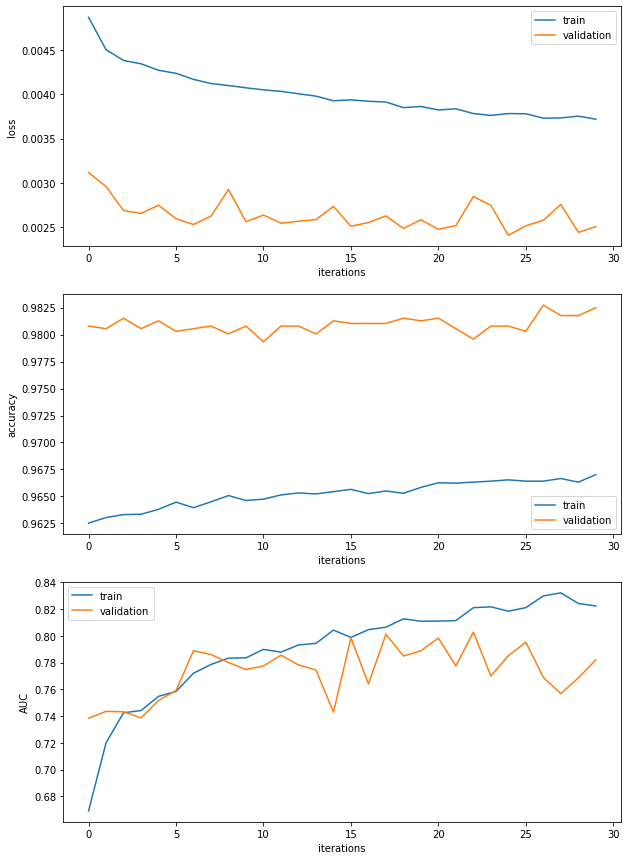

In [ ]:
display_training_plots(history_MAX)

In [ ]:
_, test_acc, test_list_preds = eval_step(model_MAX, loss_fn, test_loader, device)
test_auc = compute_roc_auc(test_list_preds)
print("Test accuracy: {:.5f}".format(test_acc))
print("Test AUC: {:.5f}".format(test_auc))

Test accuracy: 0.97082
Test AUC: 0.78123


## Repeat Classification with SUM Pooling

Now investigate the effect on the graph classification accuracy by changing the global pooling strategy to SUM, i.e., `torch_geometric.nn.global_add_pool`. Here are the steps.

1. Either copy-paste the previous network and make the necessary changes, or parameterize your original model with a `pooling_strategy` parameter.
2. Instantiate the model and set it to the correct `device`.
3. Instantiate the `CrossEntropyLoss` loss function
4. Instantiate the `Adam` optimizer with the new model parameters.
5. Run the training loop for `NUM_EPOCHS` epochs, capturing the training and validation loss and accuracies.
6. Use the list of tuples to plot the training curves for training and validation loss and accuracies.
7. Compute and report the accuracy and AUC of the network with SUM pooling against the held-out test set.

In [ ]:
class GraphClassifier_SUM(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, 
               num_graph_layers, dropout_pct):

    super(GraphClassifier_SUM, self).__init__()
    self.num_graph_layers = num_graph_layers
    self.dropout_pct = dropout_pct
    self.output_dim = output_dim
    
    # convert manually crafted categorical features to continuous
    self.encoder = AtomEncoder(hidden_dim)

    self.convs = nn.ModuleList()
    for i in range(num_graph_layers):
      self.convs.append(pyg_nn.GCNConv(hidden_dim, hidden_dim))

    self.bns = nn.ModuleList()
    for i in range(num_graph_layers - 1):
      self.bns.append(nn.BatchNorm1d(hidden_dim))

    self.clf_head = nn.Linear(hidden_dim, output_dim)

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    x = self.encoder(x)
    for i in range(self.num_graph_layers - 1):
      x = self.convs[i](x, edge_index)
      x = self.bns[i](x)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout_pct)
    x = self.convs[-1](x, edge_index)

    x = pyg_nn.global_add_pool(x, data.batch)
    x = self.clf_head(x)
    return x


In [ ]:
model_SUM = GraphClassifier_SUM(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_GCN_LAYERS, DROPOUT_PCT)
model_SUM = model_SUM.to(device)

In [ ]:
optimizer = optim.Adam(model_SUM.parameters(), lr=LEARNING_RATE)
history_SUM = train_loop(model_SUM, optimizer, loss_fn, train_loader, val_loader, device, NUM_EPOCHS)

EPOCH   1, TRAIN loss: 0.00847, acc: 0.95818, AUC: 0.53136, VAL loss: 0.00474, acc: 0.97860, AUC: 0.63119
EPOCH   5, TRAIN loss: 0.00490, acc: 0.96322, AUC: 0.68083, VAL loss: 0.00331, acc: 0.97885, AUC: 0.67661
EPOCH  10, TRAIN loss: 0.00443, acc: 0.96386, AUC: 0.72779, VAL loss: 0.00299, acc: 0.98055, AUC: 0.70280
EPOCH  15, TRAIN loss: 0.00420, acc: 0.96456, AUC: 0.76134, VAL loss: 0.00263, acc: 0.98079, AUC: 0.71865
EPOCH  20, TRAIN loss: 0.00400, acc: 0.96596, AUC: 0.77581, VAL loss: 0.00262, acc: 0.98152, AUC: 0.71455
EPOCH  25, TRAIN loss: 0.00394, acc: 0.96547, AUC: 0.78572, VAL loss: 0.00248, acc: 0.98104, AUC: 0.82142
EPOCH  30, TRAIN loss: 0.00382, acc: 0.96660, AUC: 0.80104, VAL loss: 0.00273, acc: 0.97885, AUC: 0.76528


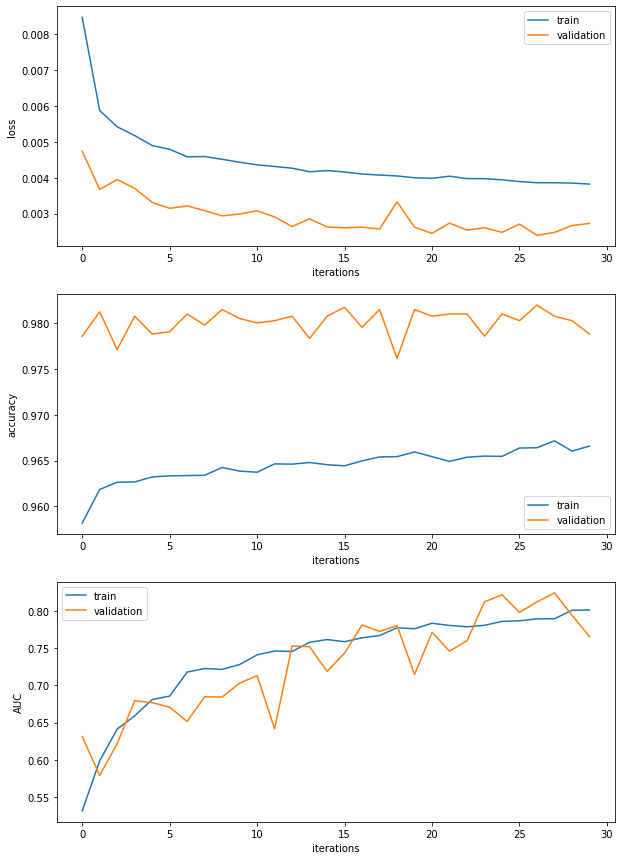

In [ ]:
display_training_plots(history_SUM)

In [ ]:
_, test_acc, test_list_preds = eval_step(model_SUM, loss_fn, test_loader, device)
test_auc = compute_roc_auc(test_list_preds)
print("Test accuracy: {:.5f}".format(test_acc))
print("Test AUC: {:.5f}".format(test_auc))

Test accuracy: 0.96475
Test AUC: 0.72230
